In [26]:
# Library of my own functions
import sys
sys.path.append("../src/")
import my_functions

# sklearn to do Random Search & ML models
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Libraries to deal with dataframes, vectors and formats
import pandas as pd
import numpy as np
import pickle as pkl

# Plotting libraries to understand the models
import seaborn as sns
import matplotlib.pyplot as plt

## 1 Preprocess

#### Comments on the original code

1. It is not good practice to drop all NA values and then delete the columns, because in this example you want to delete the Cabin column that has 687 NA values. So if you do it in that order you are going to delete 687 rows (77% of the data), because of a column that you don't care.

2. It is more readable, faster and practical to benefit from vectorization functions from pandas to work with dataframes.

3. Not using the argument index in data.to_csv() creates a new column when writing the new csv.

##### Original code
```python
    import pandas as pd
    import numpy as np

    def execute(input_file, output_file):
        data = pd.read_csv(input_file, sep = ";")
        data = data.dropna()
        del(data["Name"])
        del(data["Ticket"])
        del(data["Cabin"])
        

        data.to_csv(output_file)
```

##### My proposal
```python
    import pandas as pd

    def preprocess_roche(input_file, output_file, delete_columns = ["Name", "Ticket", "Cabin"], drop_na = True):
        """
        Preprocess a raw dataframe. It can delete one or more columns and 
        drops NA values.

        Arguments:
        input_file (str) -- Path to the csv file of the titanic dataset (The csv separator should be ";").
        output_file (str) -- Path where the new csv of the new process data is going to be saved.
        delete_columns -- List of colums to delete of the dataframe.
        drop_na -- Set True to drop all NA values.

        Returns:
        A .csv of the processed dataframe in the specified location. 
        """

        data = pd.read_csv(input_file, sep = ";")
        
        data.drop(delete_columns, axis = 1, inplace=True) 
        
        if drop_na == True:
            data.dropna(inplace=True)
        else:
            pass
        
        data.to_csv(output_file, index=False)
```

In [2]:
# Training
input_file = "../data/raw/train.csv"
output_file = "../data/preprocess/train_preprocess_roche.csv"

my_functions.preprocess_roche(input_file, output_file)

# Validation
input_file = "../data/raw/val.csv"
output_file = "../data/preprocess/val_preprocess_roche.csv"

my_functions.preprocess_roche(input_file, output_file)

## 2 Build Features

#### Comments on the original code

1. Creating new variables is sometimes useful, but creating new columns like Family Size and IsAlone is repeating information (Curse of dimensionality)

2. I believe that changing the values of the Embarked and Sex column does not make a lot of sense, because this variables are categorical and if you put numerical values in those columns Random Forest is going to treat them as numerical. That is why I created dummy variables. However, if I ever need to do that I would do it like this (Vectorization):

##### Original Code
```python
    # Change values of Sex column
    df["Sex"] = df["Sex"].replace("male", 0)
    df["Sex"] = df["Sex"].replace("female", 1)

    # Change values of Embarked column
    embarked_dict = {}
    embarked_dict_values = 0
    for i in df.Embarked:
        if i in embarked_dict.keys():
            pass
        else:
            embarked_dict_values = embarked_dict_values + 1
            embarked_dict[i] = embarked_dict_values
    
    for i in embarked_dict.keys():
        df["Embarked"].replace(i, embarked_dict[i], inplace = True)
```
##### My proposal
```python
    # Change values of Sex column
    df["Sex"].replace({"male": 0, "female": 1}, inplace=True)

    # Change values of Embarked column
    df["Embarked"].replace({"Southampton": 1, "Cherbourg": 2, "Queenstown": 3}, inplace=True)
```



In [3]:
# Training
input_file = "../data/preprocess/train_preprocess_roche.csv"
output_file = "../data/features/train_RF_roche.csv"

my_functions.build_features_roche(input_file,output_file)

# Validation
input_file = "../data/preprocess/val_preprocess_roche.csv"
output_file = "../data/features/val_RF_roche.csv"

my_functions.build_features_roche(input_file,output_file)

## 3 Train Model

#### Comments on the original code 

1. It is not a good idea to put the index column PassengerId as training variable.

2. The accuracy is not a good estimator in this example, because the classes are imbalance (People who died are 61.62% of total)

3. When evaluating a model I have found more useful to write the predictions of the model (index, True_Value, Prediction) in a csv and then calculate oll kinds of metrics. That is why I create the submoduld evaluate.py.

4. I tend to save the model after I calculate all metrics (Why save it if it's not good?)

5. For Random Forest having n_estimators=10 is a very low number of threes that is going to give very poor results.

##### Original Code
```python
    import numpy as np
    import pandas as pd
    import sklearn
    import pickle as pkl

    # Split the data for training.
    df = pd.read_csv("data/train_bf.csv")

    y = df["Survived"]

    tr_col = []
    for c in df.columns:
        if c == "Survived":
            pass
        else:
            tr_col.append(c)

    # Create a classifier and select scoring methods.
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=10)


    # Fit full model and predict on both train and test.
    clf.fit(df[tr_col], y)
    preds = clf.predict(df[tr_col])
    metric_name = "train_accuracy"
    metric_result = sklearn.metrics.accuracy_score(y, preds)

    model_pickle = open("data/model.pkl", 'wb')
    pkl.dump(clf, model_pickle)
    model_pickle.close()

    # Return metrics and model.
    info = ""
    info = info + metric_name
    info = info + " for the model is "
    info = info + str(metric_result)
    print(info)
```

##### My proposal
```python
    import pandas as pd
    from sklearn.metrics import accuracy_score 
    from sklearn.ensemble import RandomForestClassifier

    # Split data for training
    df = pd.read_csv(input_file)

    df = df.loc[:, df.columns != index_column] # Avoids using index column as training variable 

    X = df.loc[:, df.columns != target_column].values 
    y = df[target_column].values 

    # Create a classifier and select scoring methods
    clf = RandomForestClassifier(n_estimators=10)

    # Fit full model and predict 
    clf.fit(X, y)
    y_pred = clf.predict(X)

    # Return metrics and model
    accuracy = accuracy_score(y, y_pred)
    print("The train_accuracy for the model is: ", str(accuracy))

    # Save model
    with open('data/model.pkl','wb') as f:
        pickle.dump(clf,f)
```


Note:

I only have the function create_features_target() in the submodule train.py because the accuracy metrics are in the evaluate.py

#### 3.1 Create Features and Target

In [4]:
# Training 
input_file = "../data/features/train_RF_roche.csv"
X_train, y_train = my_functions.create_features_target(input_file, target_column="Survived", index_column="PassengerId")

# Validation
input_file = "../data/features/val_RF_roche.csv"
X_test, y_test = my_functions.create_features_target(input_file, target_column="Survived", index_column="PassengerId")

### 3.2 Fit the model

#### 3.2.1 Roche

In [5]:
rf_roche = RandomForestClassifier(n_estimators=10)
rf_roche.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

#### 3.2.2 Raul

In [6]:
rf_raul = RandomForestRegressor(random_state = 42)

Now we are going to create a parameter grid to sample during fitting: 

In [7]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [8]:
# Random search of parameters, using 5 fold cross validation, 
#  
rf_raul = RandomizedSearchCV(estimator = rf_raul, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 3)
rf_raul.fit(X_train, y_train) # Fit the random search model

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.5min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  9.6min
[Parallel(n_jobs=3)]: Done 500 out of 500 | elapsed: 12.9min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [9]:
rf_raul.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [10]:
rf_raul = rf_raul.best_estimator_

## 4 Evaluate Model

### 4.1 Make Predictions

#### 4.1.1 Roche

In [14]:
train_file = "../data/features/train_RF_roche.csv"
val_file = "../data/features/val_RF_roche.csv"
model = rf_roche
output_file = "../data/predictions/features_roche/predictions_RF_roche.csv"

my_functions.save_predictions(train_file, val_file, output_file, model, format_type= "csv")

#### 4.1.2 Raul

In [15]:
train_file = "../data/features/train_RF_roche.csv"
val_file = "../data/features/val_RF_roche.csv"
model = rf_raul
output_file = "../data/predictions/features_roche/predictions_RF_raul.csv"

my_functions.save_predictions(train_file, val_file, output_file, model, format_type= "csv")

### 4.2 Metrics

In [16]:
# Input File of the predictions Results
input_file_roche = "../data/predictions/features_roche/predictions_RF_roche.csv"
input_file_raul = "../data/predictions/features_roche/predictions_RF_raul.csv"

#### 4.2.1 Roche

In [17]:
my_functions.print_accuracies(input_file_roche)

The training accuracy is:  97.52 %
The training balanced accuracy is:  97.42 %

The validation accuracy is:  70.15 %
The validation balanced accuracy is:  70.33 %



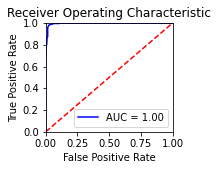

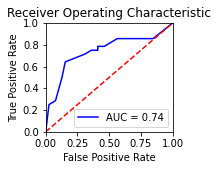

In [18]:
plt.rcParams['figure.figsize'] = [5, 2]
plt.subplot(1,2,1)
my_functions.plot_roc_curve(rf_roche, X_train, y_train)
plt.subplot(1,2,2)
my_functions.plot_roc_curve(rf_roche, X_test, y_test)

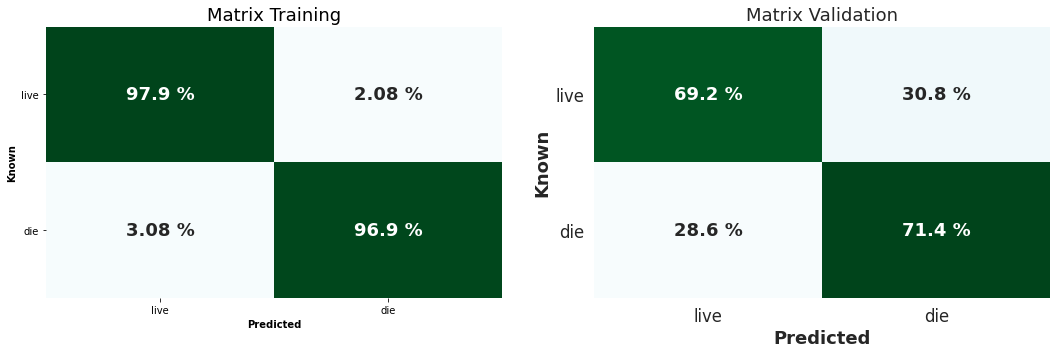

In [20]:
my_functions.plot_confusion_matrices(input_file_roche)

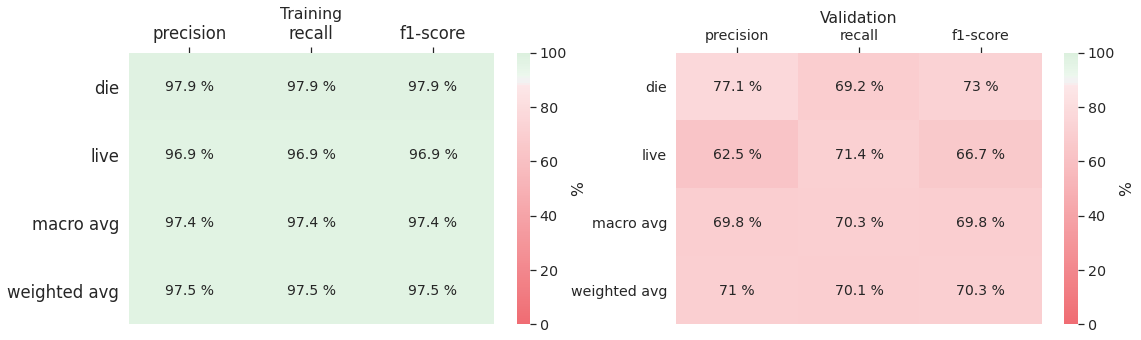

In [21]:
my_functions.plot_classification_reports(input_file_roche)

#### 4.2.2 Raul

In [22]:
my_functions.print_accuracies(input_file_raul)

The training accuracy is:  89.77 %
The training balanced accuracy is:  88.18 %

The validation accuracy is:  73.13 %
The validation balanced accuracy is:  71.89 %



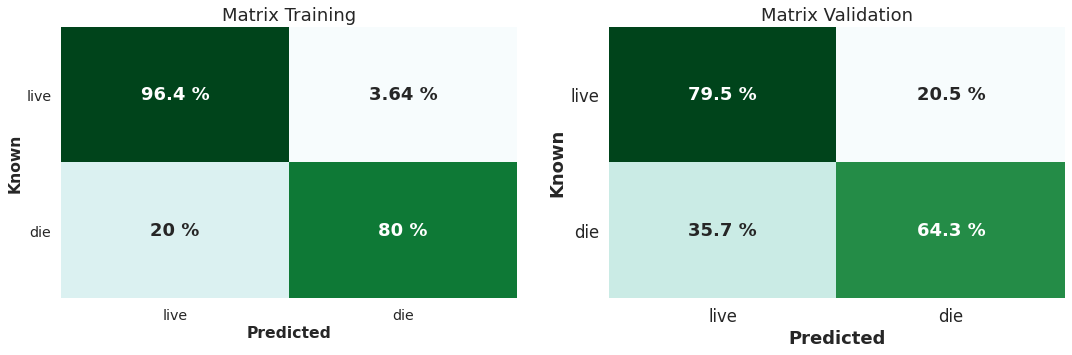

In [23]:
my_functions.plot_confusion_matrices(input_file_raul)

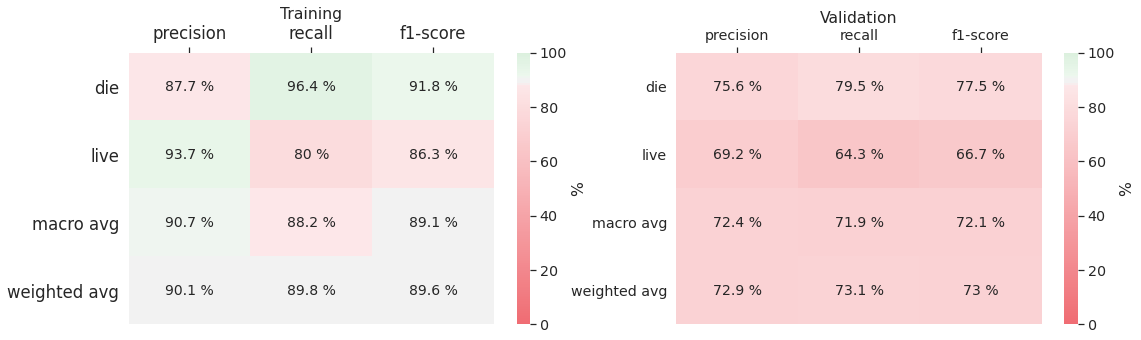

In [24]:
my_functions.plot_classification_reports(input_file_raul)

## 5 Save Models

In [27]:
# Roche
with open('../models/features_roche/rf_roche.pkl','wb') as f:
    pkl.dump(rf_roche,f)

# Raul
with open('../models/features_roche/rf_raul.pkl','wb') as f:
    pkl.dump(rf_raul,f)